# Librerías

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# Dataset

In [71]:
df = pd.read_excel("data/Dataset.xlsx")

Eliminar valores nulos:

In [35]:
df = df.dropna()

Separar datos objetivo: RON y MON

In [82]:
X = df.drop(columns=["RON", "MON", "IDENT."])
#X = df.drop(columns=["RON", "MON"])
y = df[["RON", "MON"]]

# Split train test

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalización

In [41]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_s = scaler_X.fit_transform(X_train)
X_test_s  = scaler_X.transform(X_test)
y_train_s = scaler_y.fit_transform(y_train)
y_test_s  = scaler_y.transform(y_test)

# Modelo MLP

In [43]:
mlp = MLPRegressor(random_state=42)

Búsqueda de hiperparámetros

In [45]:
param_dist = {
    "hidden_layer_sizes": [(100,), (100,50,), (150,100,50,), (200,100,50,25,)],
    "activation": ["relu", "tanh"],
    "solver": ["adam", "lbfgs"],
    "alpha": [1e-4, 1e-3, 1e-2, 1e-1],
    "learning_rate": ["constant", "adaptive"],
    "learning_rate_init": [1e-4, 1e-3, 1e-2],
    "max_iter": [500, 1000]
}

Randomized search con validación cruzada:

In [47]:
search = RandomizedSearchCV(
    estimator=mlp,
    param_distributions=param_dist,
    n_iter=50,               # prueba 50 combinaciones
    cv=5,
    scoring="r2",             # o puedes usar negativo MSE
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [49]:
search.fit(X_train_s, y_train_s)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\e0224145\AppData\Local\anaconda1\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:602: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


,estimator,MLPRegressor(random_state=42)
,param_distributions,"{'activation': ['relu', 'tanh'], 'alpha': [0.0001, 0.001, ...], 'hidden_layer_sizes': [(100,), (100, ...), ...], 'learning_rate': ['constant', 'adaptive'], ...}"
,n_iter,50
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


Mejores hiperparámetros:

In [51]:
print("Mejores hiperparámetros:", search.best_params_)

Mejores hiperparámetros: {'solver': 'lbfgs', 'max_iter': 1000, 'learning_rate_init': 0.0001, 'learning_rate': 'constant', 'hidden_layer_sizes': (200, 100, 50, 25), 'alpha': 0.1, 'activation': 'relu'}


Mejor modelo:

In [53]:
best_model = search.best_estimator_

# Evaluación del modelo

In [55]:
y_pred_s = best_model.predict(X_test_s)
y_pred = scaler_y.inverse_transform(y_pred_s)

In [57]:
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [59]:
print(f"R^2 en test: {r2:.4f}")
print(f"RMSE en test: {rmse:.4f}")

R^2 en test: 0.9944
RMSE en test: 0.5507


In [73]:
# Convertir a DataFrame para facilitar columnas
y_pred_df = pd.DataFrame(y_pred, columns=["RON", "MON"], index=y_test.index)

# === MÉTRICAS POR PROPIEDAD ===

# RON
r2_ron = r2_score(y_test["RON"], y_pred_df["RON"])
rmse_ron = np.sqrt(mean_squared_error(y_test["RON"], y_pred_df["RON"]))

# MON
r2_mon = r2_score(y_test["MON"], y_pred_df["MON"])
rmse_mon = np.sqrt(mean_squared_error(y_test["MON"], y_pred_df["MON"]))

print("Resultados por propiedad:")
print(f"R² RON: {r2_ron:.4f}")
print(f"RMSE RON: {rmse_ron:.4f}")
print(f"R² MON: {r2_mon:.4f}")
print(f"RMSE MON: {rmse_mon:.4f}")


Resultados por propiedad:
R² RON: 0.9960
RMSE RON: 0.5680
R² MON: 0.9929
RMSE MON: 0.5329


# Gráfica de comparación

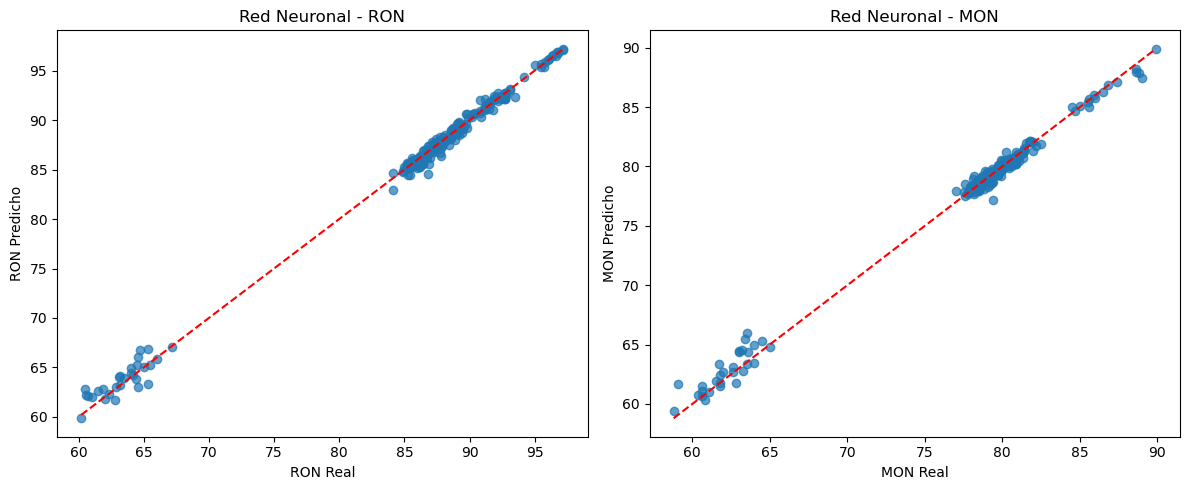

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# RON
axs[0].scatter(y_test["RON"], y_pred[:, 0], alpha=0.7)
axs[0].plot([y_test["RON"].min(), y_test["RON"].max()],
             [y_test["RON"].min(), y_test["RON"].max()], 'r--')
axs[0].set_xlabel("RON Real")
axs[0].set_ylabel("RON Predicho")
axs[0].set_title("Red Neuronal - RON")

# MON
axs[1].scatter(y_test["MON"], y_pred[:, 1], alpha=0.7)
axs[1].plot([y_test["MON"].min(), y_test["MON"].max()],
             [y_test["MON"].min(), y_test["MON"].max()], 'r--')
axs[1].set_xlabel("MON Real")
axs[1].set_ylabel("MON Predicho")
axs[1].set_title("Red Neuronal - MON")

plt.tight_layout()
plt.show()

In [84]:
import joblib
 
feature_names = X.columns.tolist()
 
artefactos = {
    "model": best_model,      # MLP entrenado (multi-salida RON/MON)
    "scaler_X": scaler_X,     # StandardScaler de X
    "scaler_y": scaler_y,     # StandardScaler de y (RON, MON)
    "feature_names": feature_names
}
 
nombre_archivo = "mlp_ron_mon_modelo.joblib"
joblib.dump(artefactos, nombre_archivo)
 
print(f"Modelo y pretratamiento guardados en: {nombre_archivo}")
 

Modelo y pretratamiento guardados en: mlp_ron_mon_modelo.joblib


C:\Users\e0224145\AppData\Local\anaconda1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


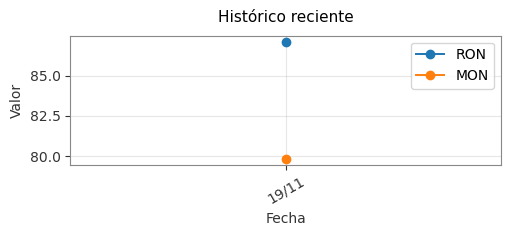

In [102]:
import os
import re
import tkinter as tk
from tkinter import filedialog, messagebox
from datetime import datetime
 
import pandas as pd
from joblib import load
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
 
# ------------------ CONFIGURACIÓN ------------------
# Modelo único con red + escaladores + nombres de variables
MODEL_JOBLIB = "mlp_ron_mon_modelo.joblib"  # ajusta ruta si es necesario
 
SPEC_RON_MIN = 84.0
 
# Colores Ecopetrol
BG = "#F4F5F4"      # fondo general suave
CARD_BG = "#FFFFFF" # fondo tarjetas
GREEN = "#184A2C"
FG = "#222"
 
plt.rcParams.update({
    "axes.edgecolor": "#888",
    "xtick.color": "#333",
    "ytick.color": "#333",
    "axes.labelcolor": "#333"
})
 
# ------------------ APP ------------------
root = tk.Tk()
root.title("Inferencia de RON/MON en Gasolinas")
root.configure(bg=BG)
root.geometry("1100x720")
 
# Hacer la grilla responsive (2 columnas x 3 filas)
root.grid_columnconfigure(0, weight=1, uniform="col")
root.grid_columnconfigure(1, weight=1, uniform="col")
root.grid_rowconfigure(1, weight=1, uniform="row")  # fila de tarjetas superiores
root.grid_rowconfigure(2, weight=1, uniform="row")  # fila de tarjetas inferiores
 
# ------------------ ENCABEZADO ------------------
header = tk.Frame(root, bg=BG)
header.grid(row=0, column=0, columnspan=2, sticky="nsew", padx=16, pady=(14, 6))
header.grid_columnconfigure(0, weight=1)
 
title = tk.Label(
    header,
    text="DEPARTAMENTO INSPECCIÓN DE CALIDAD\nINFERENCIA DE RON/MON EN GASOLINAS",
    font=("Arial", 18, "bold"),
    bg=BG, fg=GREEN,
    justify="center"
)
title.grid(row=0, column=0, sticky="n")
 
fecha_lbl = tk.Label(
    header,
    text=f"Fecha actual: {datetime.now().strftime('%d/%m/%Y')}",
    font=("Arial", 11),
    bg=BG, fg=FG,
    anchor="e", justify="right"
)
fecha_lbl.grid(row=0, column=1, sticky="ne", padx=8)
 
# ------------------ TARJETA MODELO (arriba-izquierda) ------------------
card_model = tk.Frame(root, bg=CARD_BG, bd=1, relief="groove")
card_model.grid(row=1, column=0, sticky="nsew", padx=(16, 8), pady=(6, 8))
 
tk.Label(
    card_model, text="MODELO",
    font=("Arial", 14, "bold"),
    bg=CARD_BG, fg=GREEN
).pack(anchor="w", padx=14, pady=(12, 6))
 
row = tk.Frame(card_model, bg=CARD_BG)
row.pack(fill="x", padx=14, pady=2)
tk.Label(row, text="Versión del modelo:", bg=CARD_BG, fg=FG,
         font=("Arial", 11)).pack(side="left")
tk.Label(row, text="2025.01", bg="#E9ECEF", fg=FG,
         font=("Arial", 11), padx=8, pady=2).pack(side="left", padx=8)
 
row = tk.Frame(card_model, bg=CARD_BG)
row.pack(fill="x", padx=14, pady=2)
tk.Label(row, text="Nombre del modelo:", bg=CARD_BG, fg=FG,
         font=("Arial", 11)).pack(side="left")
tk.Label(row, text="GMRRONMON", bg="#E9ECEF", fg=FG,
         font=("Arial", 11), padx=8, pady=2).pack(side="left", padx=8)
 
btn_predict = tk.Button(
    card_model,
    text="Subir Excel y Inferir",
    bg=GREEN, fg="white",
    font=("Arial", 12, "bold"),
    width=22
)
btn_predict.pack(pady=14)
 
# ------------------ TARJETA ESPECTRO (arriba-derecha) ------------------
card_spec = tk.Frame(root, bg=CARD_BG, bd=1, relief="groove")
card_spec.grid(row=1, column=1, sticky="nsew", padx=(8, 16), pady=(6, 8))
 
tk.Label(
    card_spec, text="ESPECTRO CARGADO",
    font=("Arial", 14, "bold"),
    bg=CARD_BG, fg=GREEN
).pack(anchor="w", padx=14, pady=(12, 6))
 
spec_canvas_holder = None
 
# ------------------ TARJETA RESULTADOS (abajo-izquierda) ------------------
card_res = tk.Frame(root, bg=CARD_BG, bd=1, relief="groove")
card_res.grid(row=2, column=0, sticky="nsew", padx=(16, 8), pady=(8, 16))
 
tk.Label(
    card_res, text="RESULTADOS INFERIDOS",
    font=("Arial", 14, "bold"),
    bg=CARD_BG, fg=GREEN
).pack(anchor="w", padx=14, pady=(12, 6))
 
res_body = tk.Frame(card_res, bg=CARD_BG)
res_body.pack(fill="x", padx=14, pady=6)
 
lbl_id_title = tk.Label(
    res_body,
    text="Identificación de la muestra:",
    font=("Arial", 11),
    bg=CARD_BG, fg=FG
)
lbl_id_title.grid(row=0, column=0, sticky="w", padx=(0, 8), pady=2)
 
lbl_id_val = tk.Label(
    res_body,
    text="--",
    font=("Arial", 11),
    bg="#E9ECEF", fg=FG,
    padx=8, pady=2
)
lbl_id_val.grid(row=0, column=1, sticky="w", pady=2)
 
# KPIs
kpi = tk.Frame(card_res, bg=CARD_BG)
kpi.pack(fill="x", padx=14, pady=(8, 2))
 
lblR = tk.Label(
    kpi, text="RON\n--",
    font=("Arial", 18, "bold"),
    bg="#F8FBFF", fg=FG,
    bd=1, relief="solid",
    padx=18, pady=10
)
lblR.grid(row=0, column=0, padx=(0, 16))
 
lblM = tk.Label(
    kpi, text="MON\n--",
    font=("Arial", 18, "bold"),
    bg="#FFF8F0", fg=FG,
    bd=1, relief="solid",
    padx=18, pady=10
)
lblM.grid(row=0, column=1)
 
lblC = tk.Label(
    card_res,
    text="Cumple especificación: --",
    font=("Arial", 12, "bold"),
    bg=CARD_BG, fg=FG
)
lblC.pack(anchor="w", padx=14, pady=(10, 12))
 
# ------------------ TARJETA TENDENCIAS (abajo-derecha) ------------------
card_trend = tk.Frame(root, bg=CARD_BG, bd=1, relief="groove")
card_trend.grid(row=2, column=1, sticky="nsew", padx=(8, 16), pady=(8, 16))
 
tk.Label(
    card_trend, text="TENDENCIAS",
    font=("Arial", 14, "bold"),
    bg=CARD_BG, fg=GREEN
).pack(anchor="w", padx=14, pady=(12, 6))
 
trend_canvas_holder = None
ron_hist, mon_hist, date_hist = [], [], []
 
# ------------------ CARGAR MODELO ------------------
try:
    artefactos = load(MODEL_JOBLIB)
    model = artefactos["model"]
    scaler_X = artefactos["scaler_X"]
    scaler_y = artefactos["scaler_y"]
    feature_names = artefactos["feature_names"]  # orden de entrenamiento
except Exception as e:
    messagebox.showerror("Modelo", f"No se pudo cargar el modelo:\n{e}")
    root.destroy()
 
 
# ------------------ UTILIDADES ------------------
def num_from_header(h):
    """Extrae un número float desde un encabezado tipo '3931 cm-1'."""
    s = str(h).strip().replace(",", ".")
    m = re.search(r"[-+]?\d+(?:\.\d+)?", s)
    return float(m.group()) if m else None
 
 
def plot_in_card(frame, x, y, title, invert_x=False):
    plt.close('all')
    fig, ax = plt.subplots(figsize=(6.6, 3.1))
    ax.plot(x, y, linewidth=1.4, color=GREEN)
    ax.set_xlabel("Número de onda (cm⁻¹)")
    ax.set_ylabel("Absorbancia")
    ax.set_title(title, fontsize=11, pad=10)
    ax.grid(True, alpha=0.3)
    if invert_x:
        ax.invert_xaxis()
    plt.subplots_adjust(bottom=0.22)
    fig.tight_layout(pad=1.6)
    canvas = FigureCanvasTkAgg(fig, master=frame)
    canvas.get_tk_widget().pack(fill="both", expand=True, padx=12, pady=(0, 12))
    canvas.draw()
    return canvas
 
 
def plot_trends():
    global trend_canvas_holder
    if trend_canvas_holder:
        trend_canvas_holder.get_tk_widget().destroy()
        trend_canvas_holder = None
    if not ron_hist:
        return
    plt.close('all')
    fig, ax = plt.subplots(figsize=(6.6, 3.1))
    ax.plot(date_hist, ron_hist, marker="o", linewidth=1.4, label="RON")
    ax.plot(date_hist, mon_hist, marker="o", linewidth=1.4, label="MON")
    ax.set_xlabel("Fecha")
    ax.set_ylabel("Valor")
    ax.set_title("Histórico reciente", fontsize=11, pad=10)
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.xticks(rotation=30)
    plt.subplots_adjust(bottom=0.30)
    fig.tight_layout(pad=1.6)
    trend_canvas_holder = FigureCanvasTkAgg(fig, master=card_trend)
    trend_canvas_holder.get_tk_widget().pack(
        fill="both", expand=True, padx=12, pady=(0, 12)
    )
    trend_canvas_holder.draw()
 
 
# ------------------ PREDICCIÓN ------------------
def predecir():
    global spec_canvas_holder
 
    p = filedialog.askopenfilename(
        title="Seleccionar archivo Excel",
        filetypes=[("Excel", "*.xlsx;*.xls")]
    )
    if not p:
        return
 
    try:
        df0 = pd.read_excel(p)
 
        if df0.shape[1] < 2:
            raise ValueError("El archivo debe tener una columna ID y columnas de espectro.")
 
        # ID de muestra: toma la primera celda de la primera columna
        #sample_id = str(df0.iloc[0, 0])
        sample_id = os.path.basename(p)
        if not sample_id or sample_id.lower() == "nan":
            sample_id = os.path.basename(p)
        lbl_id_val.config(text=sample_id)
 
        # ------------------------------
        # MAPEO DE COLUMNAS DEL EXCEL
        # A LAS COLUMNAS DEL MODELO
        # ------------------------------
        orig_cols = list(df0.columns)
 
        # Mapa: wavenumber_int -> nombre de columna en el Excel
        wave_to_col = {}
        for c in orig_cols:
            n = num_from_header(c)
            if n is not None:
                wave_to_col[int(round(n))] = c
 
        # Construir lista de columnas en el mismo orden de feature_names
        df_model_cols = []
        missing = []
 
        for fname in feature_names:
            if fname in orig_cols:
                # Coincidencia exacta (por ejemplo 'IDENT' o '3931 cm-1')
                df_model_cols.append(fname)
            else:
                n = num_from_header(fname)
                if n is not None:
                    key = int(round(n))
                    if key in wave_to_col:
                        df_model_cols.append(wave_to_col[key])
                    else:
                        missing.append(fname)
                else:
                    # columna no numérica que no está en el Excel
                    missing.append(fname)
 
        if missing:
            raise ValueError(
                "El archivo no contiene todas las columnas esperadas del modelo.\n"
                f"Faltan, por ejemplo: {missing[:10]}"
            )
 
        # DataFrame ya alineado con el orden del modelo
        df_model = df0[df_model_cols].copy()
 
        # ------------------------------
        # PREDICCIÓN
        # ------------------------------
        x = df_model.iloc[0:1, :].values
        x_s = scaler_X.transform(x)
        y_pred_s = model.predict(x_s)
        y_pred = scaler_y.inverse_transform(y_pred_s)
 
        ron = float(y_pred[0, 0])
        mon = float(y_pred[0, 1])
 
        # KPIs y cumplimiento
        if ron >= SPEC_RON_MIN:
            lblR.config(text=f"RON\n{ron:.1f}", fg=GREEN, bg="#F1FAF3")
            lblC.config(text="Cumple especificación: SÍ ✅", fg=GREEN)
        else:
            lblR.config(text=f"RON\n{ron:.1f}", fg="red", bg="#FFF5F5")
            lblC.config(text="Cumple especificación: NO ❌", fg="red")
 
        lblM.config(text=f"MON\n{mon:.1f}", fg=GREEN)
 
        # ------------------------------
        # ESPECTRO EN TARJETA DERECHA
        # ------------------------------
        if spec_canvas_holder:
            spec_canvas_holder.get_tk_widget().destroy()
            spec_canvas_holder = None
 
        # columnas espectrales (las que tienen número)
        spec_cols = [c for c in df_model_cols if num_from_header(c) is not None]
        x_axis = [num_from_header(c) for c in spec_cols]
        y_spec = df_model.iloc[0][spec_cols].values
 
        spec_canvas_holder = plot_in_card(
            card_spec, x_axis, y_spec,
            title=os.path.basename(p),
            invert_x=False
        )
 
        # ------------------------------
        # TENDENCIAS
        # ------------------------------
        ron_hist.append(ron)
        mon_hist.append(mon)
        date_hist.append(datetime.now().strftime("%d/%m"))
 
        if len(ron_hist) > 30:
            ron_hist.pop(0)
            mon_hist.pop(0)
            date_hist.pop(0)
 
        plot_trends()
 
        # Actualizar fecha en encabezado
        fecha_lbl.config(
            text=f"Fecha actual: {datetime.now().strftime('%d/%m/%Y %H:%M')}"
        )
 
    except Exception as e:
        messagebox.showerror("Predicción", str(e))
 
 
btn_predict.config(command=predecir)
 
# ------------------ RUN ------------------
root.mainloop() 
 
 